In [ ]:
import pandas as pd
import numpy as np
import os
import random
import pandas
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
#sns.set()
import h5py
import cv2 as cv

import tensorflow as tf
from tensorflow.keras.layers import Input, ZeroPadding2D, Activation, Dense, AveragePooling2D, GlobalAveragePooling2D, MaxPooling2D, Concatenate, SpatialDropout2D, Conv2D, Flatten, BatchNormalization, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.regularizers import l2
from tensorflow.keras.initializers import he_normal, random_normal

from tensorflow.keras import backend as K

K.set_image_data_format('channels_last')

np.set_printoptions(suppress=True)

In [ ]:
### Connecting to google drive ###
from google.colab import drive
drive.mount('/content/gdrive')

!ln -s /content/gdrive/My\ Drive/ /mydrive

In [ ]:
os.chdir('/mydrive/Magnetics/Scripts')

In [ ]:
## Useful functions

from Utils.Utils_colab import *

In [ ]:
#!unzip V11_YOLO_par_3_7680.hdf5.zip

In [ ]:
hdf5_path = '../Database/V11_YOLO_par_3_9600.hdf5'

X_train, X_dev, X_test, Y_train, Y_dev, Y_test = load_dataset_train_dev_test(hdf5_path)


In [ ]:
################ Confirming data retrieved shapes ###############

##### to rgb
X_train = gray_to_rgb(X_train)
X_dev = gray_to_rgb(X_dev)
X_test = gray_to_rgb(X_test)

print("X_train shape : " + str(X_train.shape), "X_dev shape : " + str(X_dev.shape), "X_test shape : " + str(X_test.shape)) 
print("Y_train shape : " + str(Y_train.shape), "Y_dev par shape : " + str(Y_dev.shape), "Y_test par shape : " + str(Y_test.shape)) 


X_train shape : (6720, 96, 96, 3) X_dev shape : (2400, 96, 96, 3) X_test shape : (480, 96, 96, 3)
Y_train shape : (6720, 3) Y_dev par shape : (2400, 3) Y_test par shape : (480, 3)


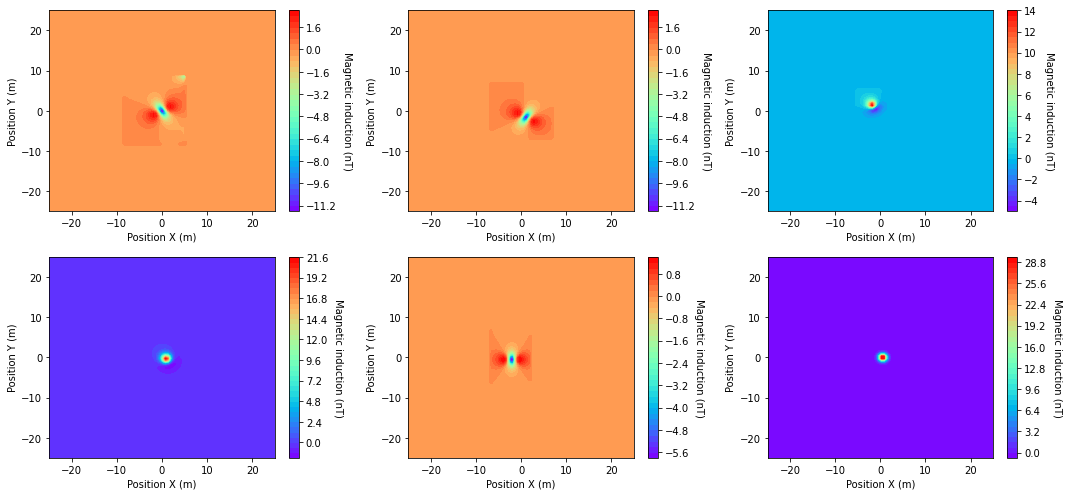

In [ ]:
zmax = X_train.shape[1]
map_lenght = 25

xmin = -map_lenght
xmax = map_lenght
ymin = -map_lenght
ymax = map_lenght

X = np.linspace(xmin, xmax, zmax)
Y = np.linspace(ymin, ymax, zmax)


# Adjust the size of your images
plt.figure(figsize=(15,7))

# Iterate and plot random images
for i in range(6):

  n_p = int(np.random.randint(0, X_train.shape[0], 1))

  plt.subplot(2, 3, i + 1)
  plt.contourf(X, Y, X_train[n_p,:,:,0], levels = 40, cmap='rainbow')
  plt.axis('on')
  plt.xlabel('Position X (m)')
  plt.ylabel('Position Y (m)')
  clb = plt.colorbar()
  clb.set_label('Magnetic induction (nT)', labelpad=15, y=0.5, rotation=270)
    
# Adjust subplot parameters to give specified padding
plt.tight_layout()

In [ ]:
"""
# Get the first image that was listed in the train_df dataframe
sample_img = X_train[20,:,:,0]
plt.contourf(X, Y, sample_img, levels = 40, cmap='rainbow')
plt.colorbar()
plt.title('Raw Chest X Ray Image')
print(f"The dimensions of the image are {sample_img.shape[0]} pixels width and {sample_img.shape[1]} pixels height, one single color channel")
print(f"The maximum pixel value is {sample_img.max():.4f} and the minimum is {sample_img.min():.4f}")
print(f"The mean value of the pixels is {sample_img.mean():.4f} and the standard deviation is {sample_img.std():.4f}")
"""

'\n# Get the first image that was listed in the train_df dataframe\nsample_img = X_train[20,:,:,0]\nplt.contourf(X, Y, sample_img, levels = 40, cmap=\'rainbow\')\nplt.colorbar()\nplt.title(\'Raw Chest X Ray Image\')\nprint(f"The dimensions of the image are {sample_img.shape[0]} pixels width and {sample_img.shape[1]} pixels height, one single color channel")\nprint(f"The maximum pixel value is {sample_img.max():.4f} and the minimum is {sample_img.min():.4f}")\nprint(f"The mean value of the pixels is {sample_img.mean():.4f} and the standard deviation is {sample_img.std():.4f}")\n'

In [ ]:
"""
# Plot a histogram of the distribution of the pixels
sns.distplot(sample_img.ravel(), label=f'Pixel Mean {np.mean(sample_img):.4f} & Standard Deviation {np.std(sample_img):.4f}', kde=False)
plt.legend(loc='upper center')
plt.title('Distribution of Pixel Intensities in the Image')
plt.xlabel('Pixel Intensity')
plt.ylabel('# Pixels in Image')
"""

"\n# Plot a histogram of the distribution of the pixels\nsns.distplot(sample_img.ravel(), label=f'Pixel Mean {np.mean(sample_img):.4f} & Standard Deviation {np.std(sample_img):.4f}', kde=False)\nplt.legend(loc='upper center')\nplt.title('Distribution of Pixel Intensities in the Image')\nplt.xlabel('Pixel Intensity')\nplt.ylabel('# Pixels in Image')\n"

In [ ]:
"""
def standardize(image):
  
  # initialize to array of zeros, with same shape as the image
  standardized_image = np.zeros(image.shape)

  c = image.shape[3]

  for c in range(image.shape[3]):

    for i in range(0, image.shape[0], 1):

    
      # get a slice of the image 
      # at channel c and z-th dimension `z`
      image_slice = image[i,:,:,c]

      # subtract the mean from image_slice
      centered = image_slice - np.mean(image_slice, axis=(0,1))

      if np.std(image_slice, axis=(0,1)) == 0 :

        centered_scaled = centered/np.std(image_slice, axis=(0,1)) + 0.000001

      else: 

        centered_scaled = centered/np.std(image_slice, axis=(0,1)) 

      # update  the slice of standardized image
      # with the scaled centered and scaled image
      standardized_image[i, :, :, c] = centered_scaled

    ### END CODE HERE ###

  return standardized_image
"""

'\ndef standardize(image):\n  \n  # initialize to array of zeros, with same shape as the image\n  standardized_image = np.zeros(image.shape)\n\n  c = image.shape[3]\n\n  for c in range(image.shape[3]):\n\n    for i in range(0, image.shape[0], 1):\n\n    \n      # get a slice of the image \n      # at channel c and z-th dimension `z`\n      image_slice = image[i,:,:,c]\n\n      # subtract the mean from image_slice\n      centered = image_slice - np.mean(image_slice, axis=(0,1))\n\n      if np.std(image_slice, axis=(0,1)) == 0 :\n\n        centered_scaled = centered/np.std(image_slice, axis=(0,1)) + 0.000001\n\n      else: \n\n        centered_scaled = centered/np.std(image_slice, axis=(0,1)) \n\n      # update  the slice of standardized image\n      # with the scaled centered and scaled image\n      standardized_image[i, :, :, c] = centered_scaled\n\n    ### END CODE HERE ###\n\n  return standardized_image\n'

In [ ]:
"""
# update  the slice of standardized image
# with the scaled centered and scaled image

X_train_std = standardize(X_train)
X_dev_std = standardize(X_dev)
X_test_std = standardize(X_test)
"""

'\n# update  the slice of standardized image\n# with the scaled centered and scaled image\n\nX_train_std = standardize(X_train)\nX_dev_std = standardize(X_dev)\nX_test_std = standardize(X_test)\n'

In [ ]:
"""
# Get the first image that was listed in the train_df dataframe

ex_p = int(np.random.randint(0, X_train.shape[0], 1))

sample_img_std = X_train_std[ex_p,:,:,0]
plt.contourf(X, Y, sample_img_std, levels = 40, cmap='rainbow')
plt.colorbar()
plt.title('Raw Chest X Ray Image')
print(f"The dimensions of the image are {sample_img_std.shape[0]} pixels width and {sample_img_std.shape[1]} pixels height, one single color channel")
print(f"The maximum pixel value is {sample_img_std.max():.4f} and the minimum is {sample_img_std.min():.4f}")
print(f"The mean value of the pixels is {sample_img_std.mean():.4f} and the standard deviation is {sample_img_std.std():.4f}")
"""

'\n# Get the first image that was listed in the train_df dataframe\n\nex_p = int(np.random.randint(0, X_train.shape[0], 1))\n\nsample_img_std = X_train_std[ex_p,:,:,0]\nplt.contourf(X, Y, sample_img_std, levels = 40, cmap=\'rainbow\')\nplt.colorbar()\nplt.title(\'Raw Chest X Ray Image\')\nprint(f"The dimensions of the image are {sample_img_std.shape[0]} pixels width and {sample_img_std.shape[1]} pixels height, one single color channel")\nprint(f"The maximum pixel value is {sample_img_std.max():.4f} and the minimum is {sample_img_std.min():.4f}")\nprint(f"The mean value of the pixels is {sample_img_std.mean():.4f} and the standard deviation is {sample_img_std.std():.4f}")\n'

In [ ]:
"""
# Plot a histogram of the distribution of the pixels

sns.distplot(sample_img_std.ravel(), label=f'Pixel Mean {np.mean(sample_img_std):.4f} & Standard Deviation {np.std(sample_img_std):.4f}', kde=False)
plt.legend(loc='upper center')
plt.title('Distribution of Pixel Intensities in the Image')
plt.xlabel('Pixel Intensity')
plt.ylabel('# Pixels in Image')
"""

"\n# Plot a histogram of the distribution of the pixels\n\nsns.distplot(sample_img_std.ravel(), label=f'Pixel Mean {np.mean(sample_img_std):.4f} & Standard Deviation {np.std(sample_img_std):.4f}', kde=False)\nplt.legend(loc='upper center')\nplt.title('Distribution of Pixel Intensities in the Image')\nplt.xlabel('Pixel Intensity')\nplt.ylabel('# Pixels in Image')\n"

In [ ]:
flag = "parameters"

Y_train_par, Y_dev_par, Y_test_par = parameters_to_use(Y_train, Y_dev, Y_test, flag)

print(Y_train_par.shape)
print(Y_dev_par.shape)
print(Y_test_par.shape)

(6720, 2)
(2400, 2)
(480, 2)


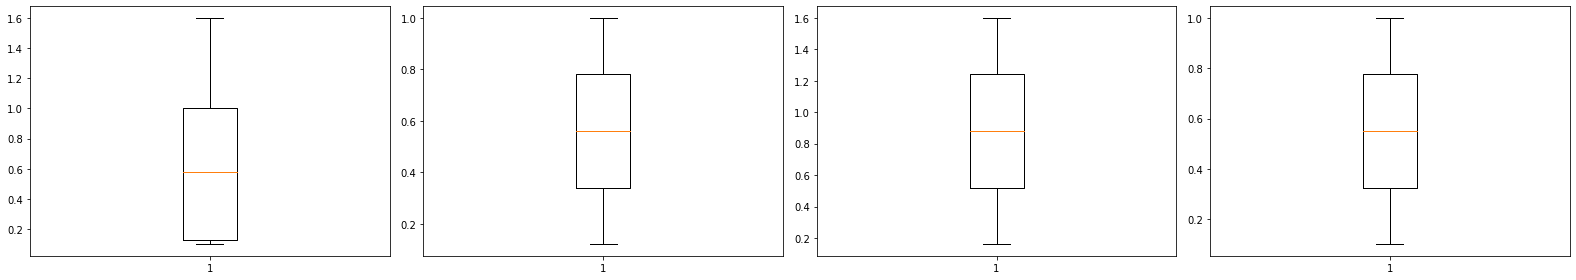

In [ ]:
y = np.concatenate((Y_train_par[0], Y_dev_par[0], Y_test_par[0]))

fig, axs = plt.subplots(1, 4, figsize=(22, 4))

# Generate box plot
axs[0].boxplot(y)
axs[1].boxplot(Y_train_par[0])
axs[2].boxplot(Y_dev_par[0])
axs[3].boxplot(Y_test_par[0])
#plt.title('boxplot')
#plt.show()
plt.tight_layout()

In [ ]:
Densenet_121 = tf.keras.applications.DenseNet121(
                                                include_top=False,
                                                weights="imagenet",
                                                input_tensor=None,
                                                input_shape=X_train.shape[1:],
                                                pooling=None,
                                                classes=1000,
                                                )

Densenet_121.summary()

29089792/29084464 [==============================] - 1s 0us/step
Model: "densenet121"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 96, 96, 3)]  0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 102, 102, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 48, 48, 64)   9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 48, 48, 64)   256         conv1/conv[0][0]                 
_______________________

In [ ]:
#i=0
#for layer in Densenet_121.layers:
  
 # print(f"{i}_{layer.name}")
 # i+=1

In [ ]:
x_out = Densenet_121.layers[311].output

x = GlobalAveragePooling2D()(x_out)

x = Dense(256, activation= "relu", name='fc6')(x)
x = Dense(256, activation= "relu", name='fc7')(x)
x = Dense(128, activation= "relu", name='fc8')(x)
x = Dense(128, activation= "relu", name='fc9')(x)
x = Dense(64, activation= "relu", name='fc10')(x)

x = Dense(Y_train_par.shape[1], activation= "linear", name='rotation')(x)

model = Model(inputs = Densenet_121.input, outputs = x)

model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 96, 96, 3)]  0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 102, 102, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 48, 48, 64)   9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 48, 48, 64)   256         conv1/conv[0][0]                 
_______________________________________________________________________________________

In [ ]:
for layer in model.layers[:139]:
#for layer in position_model.layers[:9]:
  layer.trainable=False
for layer in model.layers[139:]:
#for layer in position_model.layers[9:]:
  layer.trainable=True

In [ ]:
from keras import backend as K

def r2(y_true, y_pred):

    SS_res =  K.sum(K.square( y_true-y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

In [ ]:
from tensorflow.keras.losses import Huber, MAE

adam = Adam(learning_rate = 1e-4, beta_1=0.9, beta_2=0.999)

#sgd = SGD(lr=3e-2, decay=1e-6, momentum=0.9, nesterov=True)
            
model.compile(optimizer = adam, 
              loss= Huber(delta=1),
              metrics= [MAE, r2])


In [ ]:
path = '/content/gdrive/My Drive/YOLOv4_magnetics/Parameters/Weights/Paramaters/Densenet_par_6_TL.hdf5'

earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode="min", patience=20, verbose=0)

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(path, monitor="val_loss", verbose=0, save_best_only=True)

#reduce_lr = tensorflow.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.4, mode="min",
                                                         #patience=15, min_delta=0.05, min_lr=0.000001, verbose=0)

####### Training #####

model.fit(X_train, Y_train_par, validation_data=(X_dev, Y_dev_par), batch_size= 32, epochs=100, shuffle=True, callbacks=[model_checkpoint, earlystopping])
                                                        


Epoch 1/100
210/210 [==============================] - 6s 30ms/step - loss: 0.0267 - mean_absolute_error: 0.0943 - r2: 0.8466 - val_loss: 0.0013 - val_mean_absolute_error: 0.0376 - val_r2: 0.9930
Epoch 2/100
210/210 [==============================] - 5s 25ms/step - loss: 9.0276e-04 - mean_absolute_error: 0.0265 - r2: 0.9950 - val_loss: 0.0011 - val_mean_absolute_error: 0.0304 - val_r2: 0.9941
Epoch 3/100
210/210 [==============================] - 5s 24ms/step - loss: 7.2011e-04 - mean_absolute_error: 0.0237 - r2: 0.9960 - val_loss: 0.0011 - val_mean_absolute_error: 0.0309 - val_r2: 0.9943
Epoch 4/100
210/210 [==============================] - 5s 24ms/step - loss: 5.4178e-04 - mean_absolute_error: 0.0205 - r2: 0.9970 - val_loss: 3.6071e-04 - val_mean_absolute_error: 0.0188 - val_r2: 0.9981
Epoch 5/100
210/210 [==============================] - 5s 24ms/step - loss: 4.3518e-04 - mean_absolute_error: 0.0186 - r2: 0.9976 - val_loss: 3.7820e-04 - val_mean_absolute_error: 0.0175 - val_r2: 0.9

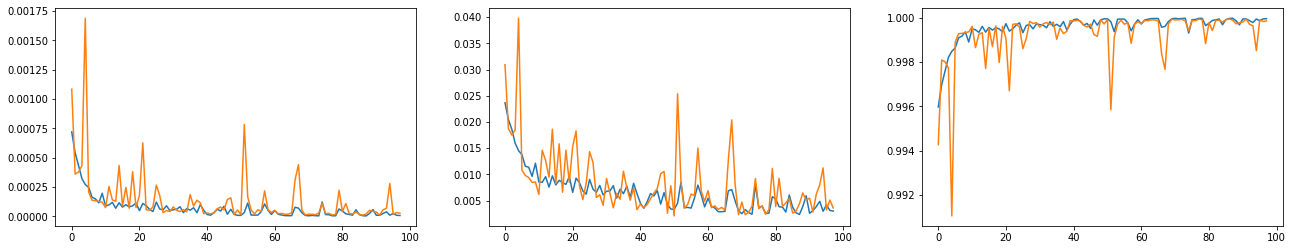

In [ ]:
###################### Plotting train_val loss vs iterations #########################
fig, axs = plt.subplots(1,3, figsize=(22,4))


axs[0].plot(model.history.history['loss'][2:])
axs[0].plot(model.history.history['val_loss'][2:])
#axs[0].title('Learning curve')
#axs[0].ylabel('Loss')
#axs[0].xlabel('Training iterations')
#plt.yticks(np.arange(0,np.max(history_fold[best_fold-1].history['loss'])+1, 2))
#axs[0].legend(['Training set', 'Validation set'], loc='upper right')

axs[1].plot(model.history.history['mean_absolute_error'][2:])
axs[1].plot(model.history.history['val_mean_absolute_error'][2:])
#axs[1].title('Learning curve')
#axs[1].ylabel('Loss')
#axs[1].xlabel('Training iterations')
#plt.yticks(np.arange(0,np.max(history_fold[best_fold-1].history['loss'])+1, 2))
#axs[1].legend(['Training set', 'Validation set'], loc='upper right')

axs[2].plot(model.history.history['r2'][2:])
axs[2].plot(model.history.history['val_r2'][2:])

plt.show()



In [ ]:
load_path = "/content/gdrive/My Drive/YOLOv4_magnetics/Parameters/Weights/Paramaters/Densenet_par_5_TL.hdf5"

best_model = load_model(load_path, custom_objects={'r2': r2})


In [ ]:
####### Evaluating test set ##########
train_loss= best_model.evaluate(X_train, Y_train_par, verbose=0)
dev_loss= best_model.evaluate(X_dev, Y_dev_par, verbose=0)
test_loss= best_model.evaluate(X_test, Y_test_par, verbose=0)

#print(f"Train loss = {np.round(train_loss,decimals=5)}, Train accuracy = {np.round(train_acc, decimals=3)}")
#print(f"Dev loss = {np.round(dev_loss, decimals=5)}, Dev accuracy = {np.round(dev_acc, decimals=3)}")
#print(f"Test loss = {np.round(test_loss, decimals=5)}, Test accuracy = {np.round(test_acc, decimals=3)}")

print(f"Train loss = {np.round(train_loss,decimals=5)}")
print(f"Dev loss = {np.round(dev_loss, decimals=5)}")
print(f"Test loss = {np.round(test_loss, decimals=5)}")


Train loss = [0.00001 0.99998]
Dev loss = [0.00004 0.99988]
Test loss = [0.00004 0.99988]


In [ ]:
####### Predicting test set ##########

Parameters_predictions_norm = best_model.predict(X_test, verbose=0)

Y_test_par[:,0] = np.round(Y_test_par[:,0], decimals = 2)
Y_test_par[:,1] = np.round(Y_test_par[:,1], decimals = 1)

Parameters_predictions_norm[:,0] = np.round(Parameters_predictions_norm[:,0], decimals = 2)
Parameters_predictions_norm[:,1] = np.round(Parameters_predictions_norm[:,1], decimals = 1)


[0.14 1.6 ]
[0.14 1.6 ]


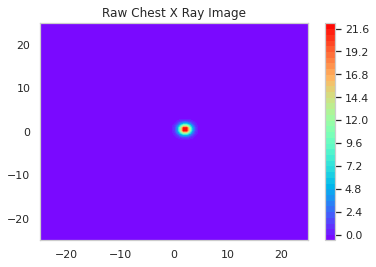

In [ ]:
nn = np.random.randint(X_test.shape[0])

zmax= 32

conversion = (25*2)/zmax

sample_img = X_test[nn,:,:,0]
plt.contourf(X, Y, sample_img, levels = 40, cmap='rainbow')
plt.colorbar()
plt.title('Raw Chest X Ray Image')

print(Y_test_par[nn])
print(Parameters_predictions_norm[nn])


In [ ]:
#Volume_real = np.around(Volume_predictions, decimals=2)
r_real = Y_test_par[:,0]

#Depth_real = np.around(Y_test_params[:,5:10], decimals=2)
Depth_real = Y_test_par[:,1]

In [ ]:
#Volume_real = np.around(Volume_predictions, decimals=2)
r_predicted = Parameters_predictions_norm[:,0]

#Depth_real = np.around(Y_test_params[:,5:10], decimals=2)
Depth_predicted = Parameters_predictions_norm[:,1]

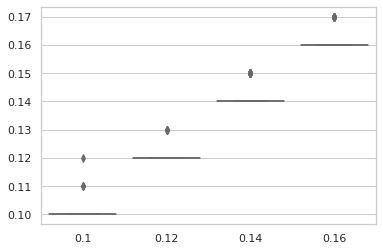

In [ ]:
#df = pd.DataFrame(Volume_real[:,0], columns=Volume_predictions[:,0])
#df_2 = pd.DataFrame(Y_test_params[:,0], columns=['Dipole 1'])
#df.plot.box(grid='True')
#df_2.plot.box(grid='True')

#ax = plt.yticks(np.arange(np.min(Volume_predictions),np.max(Volume_predictions), 2))

sns.set(style="whitegrid")
ax = sns.boxplot(x=r_real[:], y=r_predicted[:], palette="Set3")

#plt.setp(ax,xticks=(np.arange(0,np.max(Volume_real)+0.05, 0.2)))
#plt.setp(ax,yticks=(np.arange(0,np.max(Volume_predictions)+0.05, 0.2))) 


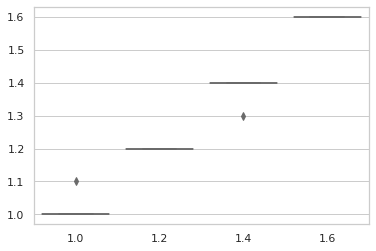

In [ ]:
sns.set(style="whitegrid")
ax = sns.boxplot(x=Depth_real[:], y=Depth_predicted[:], palette="Set3")

In [ ]:
def compute_class_sens_spec(pred, label, class_num):

  # extract sub-array for specified class
  class_pred = pred[class_num]
  class_label = label[class_num]

  ### START CODE HERE (REPLACE INSTANCES OF 'None' with your code) ###
  
  # compute:
  
  # true positives
  tp = np.sum((label == 1) & (pred == 1))

  # true negatives
  tn = np.sum((label == 0) & (pred == 0))
  
  #false positives
  fp = np.sum((label == 0) & (pred == 1))
  
  # false negatives
  fn = np.sum((label == 1) & (pred == 0))

  # compute sensitivity and specificity
  sensitivity = tp/ (tp + fn)
  specificity = tn / (tn + fp)

  return sensitivity, specificity

In [ ]:
sensitivity, specificity = compute_class_sens_spec(patch_pred[0], y, 2)


In [ ]:
def get_sens_spec_df(pred, label):
  
  patch_metrics = pd.DataFrame(
      columns = ['Edema', 
                  'Non-Enhancing Tumor', 
                  'Enhancing Tumor'], 
      index = ['Sensitivity',
                'Specificity'])
  
  for i, class_name in enumerate(patch_metrics.columns):
      sens, spec = compute_class_sens_spec(pred, label, i)
      patch_metrics.loc['Sensitivity', class_name] = round(sens,4)
      patch_metrics.loc['Specificity', class_name] = round(spec,4)

  return patch_metrics

In [ ]:
df = get_sens_spec_df(patch_pred[0], y)

print(df)

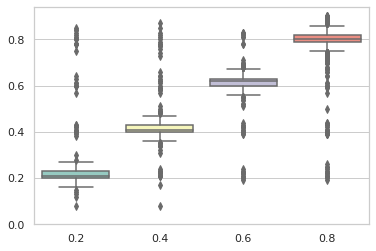

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

#df = pd.DataFrame(Volume_real[:,0], columns=Volume_predictions[:,0])
#df_2 = pd.DataFrame(Y_test_params[:,0], columns=['Dipole 1'])
#df.plot.box(grid='True')
#df_2.plot.box(grid='True')

#ax = plt.yticks(np.arange(np.min(Volume_predictions),np.max(Volume_predictions), 2))

sns.set(style="whitegrid")
ax = sns.boxplot(x=Volume_real[:], y=Volume_predictions[:-1], palette="Set3")

#plt.setp(ax,xticks=(np.arange(0,np.max(Volume_real)+0.05, 0.2)))
plt.setp(ax,yticks=(np.arange(0,np.max(Volume_predictions)+0.05, 0.2))) 


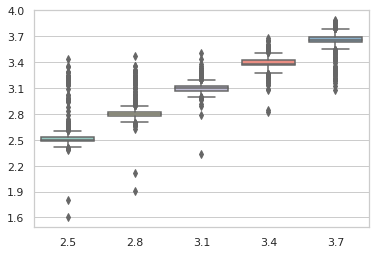

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

sns.set(style="whitegrid")
ax = sns.boxplot(x=Depth_real[:], y=Depth_predictions[:], palette="Set3")

plt.setp(ax, yticks=(np.arange(1.6,np.max(Depth_predictions)+0.2, 0.3)))


In [ ]:
from sklearn.metrics import mean_squared_error

def result_plot(Volume_predictions, Volume_real, Depth_predictions, Depth_real):

    # check the accuracy of predicted data and plot the result
    print('Volume Root Mean Square Error is:', '{:.5f}'.format(np.sqrt(mean_squared_error(Volume_real, Volume_predictions[:-1]))))
    print('Depth Root Mean Square Error is:', '{:.5f}'.format(np.sqrt(mean_squared_error(Depth_real, Depth_predictions))))


    Volume_predict = Volume_predictions
    Depth_predict = Depth_predictions

    Volume_real = Volume_real
    Depth_real = Depth_real

    nrows=2
    ncols=2
    plt.subplots(nrows, ncols, figsize=(18,8))

    plt.subplot(nrows, ncols, 1)
    plt.plot(Volume_real[:100])
    plt.plot(Volume_predict[:101])
    plt.legend(['True', 'Predicted'])
    plt.xlabel('Sample')
    plt.ylabel('Volume')
    plt.title('Volume Prediction Comparison')

    plt.subplot(nrows, ncols, 2)
    plt.plot(Depth_real[:100])
    plt.plot(Depth_predict[:100])
    plt.legend(['True', 'Predicted'])
    plt.xlabel('Sample')
    plt.ylabel('Depth')
    plt.title('Depth Prediction Comparison')

    plt.subplot(nrows, ncols, 3)
    plt.scatter(Volume_real, Volume_predict[:-1])
    plt.xlabel('Real Value')
    plt.ylabel('Predicted Value')
    #plt.title('Volume Prediction Comparison')
    #df.plot.box(grid='True')

    plt.subplot(nrows, ncols, 4)
    plt.scatter(Depth_real, Depth_predict)
    plt.xlabel('Real Value')
    plt.ylabel('Predicted Value')
    #plt.title('Depth Prediction Comparison')
    #df = pd.DataFrame(np.random.rand(10, 5), columns=['0', 'B', 'C', 'D', 'E'])
    #df.plot.box(grid='True')

Volume Root Mean Square Error is: 0.14761
Depth Root Mean Square Error is: 0.08113


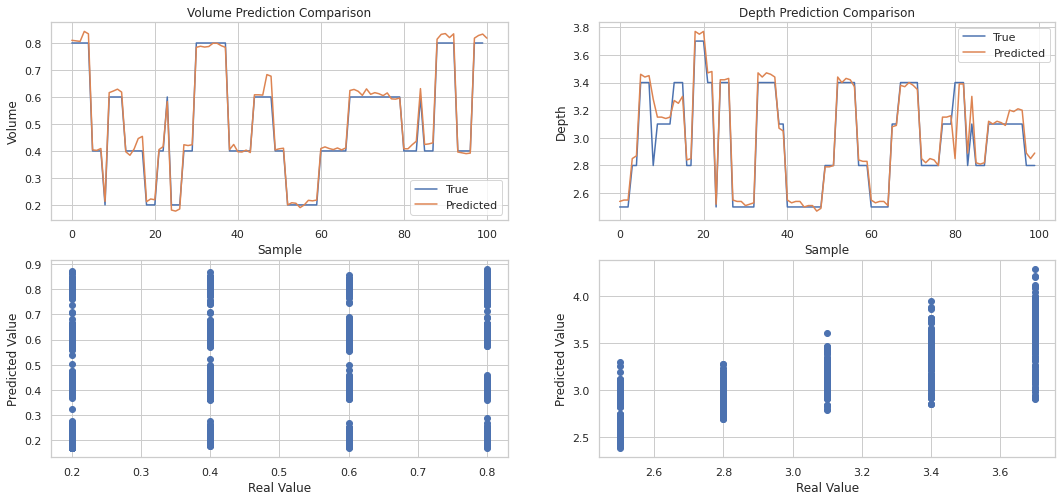

In [ ]:
result_plot(Volume_predictions, Volume_real, Depth_predictions, Depth_real)

In [ ]:
Position_X_predictions = np.around(Predictions[2][:,:5], decimals=0)
Position_X_predictions = Position_X_predictions[Position_X_predictions < 100]
#Position_X_predictions = Position_X_predictions[Position_X_predictions != 0]
print(np.min(Position_X_predictions))


Position_Y_predictions = np.around(Predictions[2][:,5:10], decimals=0)
Position_Y_predictions = Position_Y_predictions[Position_Y_predictions < 100]
#Position_Y_predictions = Position_Y_predictions[Position_Y_predictions != 0]
print(np.min(Position_Y_predictions))

-50.0
-50.0


In [ ]:
Position_X_real = Y_test_pos[:,:5]
Position_X_real = Position_X_real[Position_X_real < 100]
#Position_X_real = Position_X_real[Position_X_real != 0]
print(np.min(Position_X_real))

Position_Y_real = Y_test_pos[:,5:10]
Position_Y_real = Position_Y_real[Position_Y_real < 100]
#Position_Y_real = Position_Y_real[Position_Y_real != 0]
print(np.min(Position_Y_real))

-50.0
-50.0


In [ ]:
print(Position_X_real.shape)
print(Position_Y_real.shape)
print("---------")
print(Position_X_predictions.shape)
print(Position_Y_predictions.shape)

(20000,)
(20000,)
---------
(20000,)
(20000,)


In [ ]:
from sklearn.metrics import mean_squared_error

def result_plot(Position_X_predictions, Position_Y_predictions, Position_X_real, Position_Y_real):

    # check the accuracy of predicted data and plot the result
    print('Position X Root Mean Square Error is:', '{:.5f}'.format(np.sqrt(mean_squared_error(Position_X_real, Position_X_predictions))))
    print('Position Y Root Mean Square Error is:', '{:.5f}'.format(np.sqrt(mean_squared_error(Position_Y_real, Position_Y_predictions))))

    nrows=2
    ncols=2
    plt.subplots(nrows, ncols, figsize=(18,8))

    plt.subplot(nrows, ncols, 1)
    plt.plot(Position_X_real[:100])
    plt.plot(Position_X_predictions[:100])
    plt.legend(['True', 'Predicted'])
    plt.xlabel('Sample')
    plt.ylabel('Position X')
    plt.title('Position x Prediction Comparison')

    plt.subplot(nrows, ncols, 2)
    plt.plot(Position_Y_real[:100])
    plt.plot(Position_Y_predictions[:100])
    plt.legend(['True', 'Predicted'])
    plt.xlabel('Sample')
    plt.ylabel('Position Y')
    plt.title('Position y Prediction Comparison')

    plt.subplot(nrows, ncols, 3)
    plt.scatter(Position_X_real[:], Position_X_predictions[:])
    plt.xlabel('Real Value')
    plt.ylabel('Predicted Value')
    #plt.title('Position X Prediction Comparison')

    plt.subplot(nrows, ncols, 4)
    plt.scatter(Position_Y_real[:], Position_Y_predictions[:])
    plt.xlabel('Real Value')
    plt.ylabel('Predicted Value')
    #plt.title('Position Y Prediction Comparison')

Position X Root Mean Square Error is: 0.07036
Position Y Root Mean Square Error is: 0.06964


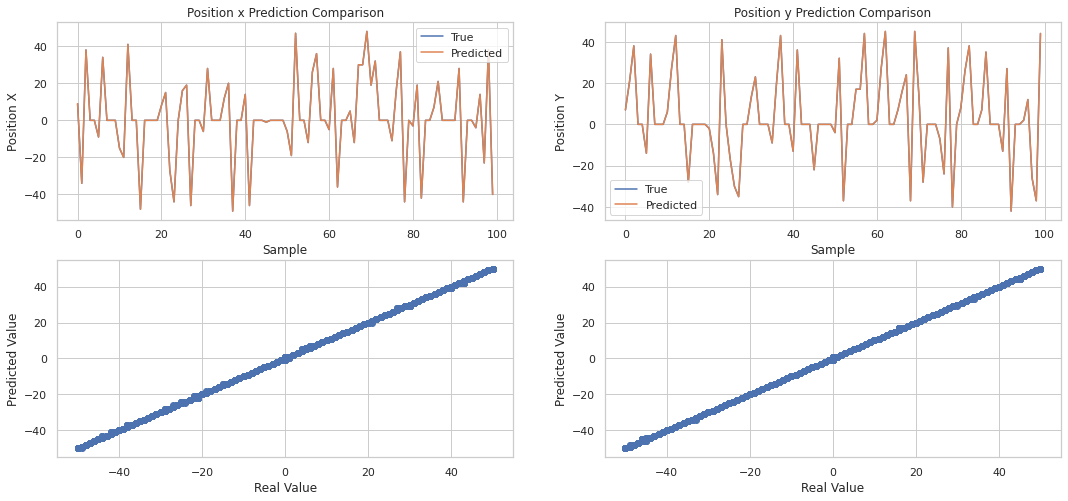

In [ ]:
result_plot(Position_X_predictions, Position_Y_predictions, Position_X_real, Position_Y_real)


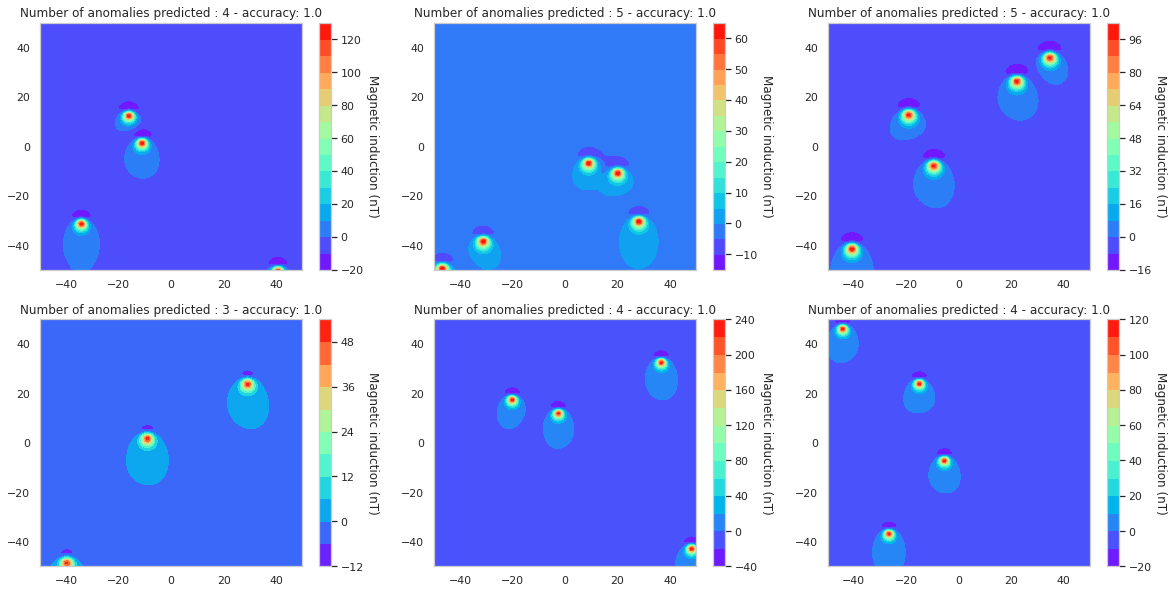

In [ ]:
zmax = 200
map_lenght = 50

xmin = -map_lenght
xmax = map_lenght
ymin = -map_lenght
ymax = map_lenght

X = np.linspace(xmin, xmax, zmax)
Y = np.linspace(ymin, ymax, zmax)

nrows = 2
ncols = 3
plt.subplots(nrows, ncols, figsize=(20,10))

examples = np.random.randint(6,len(Predictions[0]),size=1)
n_plot = 1

for ex_n in np.arange(examples-6,examples,1):

  model_to_plot = ex_n

  img_class = np.argmax(Predictions[0][ex_n])

  if img_class == 0:

    class_1 = "Number of anomalies predicted : 1 - " + "accuracy: " + str(np.round(np.max(Predictions[0][ex_n]), decimals= 3))

    plt.subplot(nrows, ncols, n_plot)
    plt.title(class_1)
    plt.contourf(X, Y, X_test[model_to_plot,:,:,0], levels = 10, cmap='rainbow')
    plt.axis('off')

    clb = plt.colorbar()
    clb.set_label('Magnetic induction (nT)', labelpad=15, y=0.5, rotation=270)

  elif img_class == 1:

    class_1 = "Number of anomalies predicted : 2 - " + "accuracy: " + str(np.round(np.max(Predictions[0][ex_n]), decimals= 3))

    plt.subplot(nrows, ncols, n_plot)
    plt.title(class_1)
    plt.contourf(X, Y, X_test[model_to_plot,:,:,0], levels = 10, cmap='rainbow')
    plt.axis('on')

    clb = plt.colorbar()
    clb.set_label('Magnetic induction (nT)', labelpad=15, y=0.5, rotation=270)

  elif img_class == 2:

    class_1 = "Number of anomalies predicted : 3 - " + "accuracy: " + str(np.round(np.max(Predictions[0][ex_n]), decimals= 3))

    plt.subplot(nrows, ncols, n_plot)
    plt.title(class_1)
    plt.contourf(X, Y, X_test[model_to_plot,:,:,0], levels = 10, cmap='rainbow')
    plt.axis('on')

    clb = plt.colorbar()
    clb.set_label('Magnetic induction (nT)', labelpad=15, y=0.5, rotation=270)

  elif img_class == 3:

    class_1 = "Number of anomalies predicted : 4 - " + "accuracy: " + str(np.round(np.max(Predictions[0][ex_n]), decimals= 3))

    plt.subplot(nrows, ncols, n_plot)
    plt.title(class_1)
    plt.contourf(X, Y, X_test[model_to_plot,:,:,0], levels = 15, cmap='rainbow')
    plt.axis('on')

    clb = plt.colorbar()
    clb.set_label('Magnetic induction (nT)', labelpad=15, y=0.5, rotation=270)

  else:

    class_2 = "Number of anomalies predicted : 5 - " + "accuracy: " + str(np.round(np.max(Predictions[0][ex_n]), decimals = 3))

    plt.subplot(nrows, ncols, n_plot)
    plt.title(class_2)
    plt.contourf(X, Y, X_test[model_to_plot,:,:,0], levels = 15, cmap='rainbow')
    plt.axis('on')

    clb = plt.colorbar()
    clb.set_label('Magnetic induction (nT)', labelpad=15, y=0.5, rotation=270)

  n_plot+=1

In [ ]:
def convolutional_layers_plot(convolutional_layer, X_test):

  zmax = X_test.shape[0]
  map_lenght = 50

  xmin = -map_lenght
  xmax = map_lenght
  ymin = -map_lenght
  ymax = map_lenght

  X = np.linspace(xmin, xmax, zmax)
  Y = np.linspace(ymin, ymax, zmax)

  nrows = 2
  ncols = int(convolutional_layer.shape[2]/nrows)

  # check the accuracy of predicted data and plot the result

  plt.subplots(nrows, ncols, figsize=(20,5))

  plt.subplot(nrows, ncols, 1)
  plt.contourf(X, Y, X_test[:,:,0], levels = 40, cmap='rainbow')
  plt.axis('off')
  #plt.legend(['True', 'Predicted'])
  #plt.xlabel('Sample')
  #plt.ylabel('DTC')
  #plt.title('DTC Prediction Comparison')

  zmax = convolutional_layer.shape[0]
  map_lenght = 50

  xmin = -map_lenght
  xmax = map_lenght
  ymin = -map_lenght
  ymax = map_lenght

  X = np.linspace(xmin, xmax, zmax)
  Y = np.linspace(ymin, ymax, zmax)

  for il in range(2,convolutional_layer.shape[2]+1,1):

    plt.subplot(nrows, ncols, il)
    plt.contourf(X, Y, convolutional_layer[:,:,il-2], levels = 40, cmap='rainbow')
    plt.axis('off')
    #plt.legend(['True', 'Predicted'])
    #plt.xlabel('Sample')
    #plt.ylabel('DTC')
    #plt.title('DTC Prediction Comparison')


  plt.show()

In [ ]:
Model_layer_to_verify = 13
Example_to_verify = 0

print(saved_model.layers[Model_layer_to_verify])

get_3rd_layer_output = K.function([saved_model.layers[0].input], [saved_model.layers[Model_layer_to_verify].output])
example_layer_output = layer_output = get_3rd_layer_output([X_test[Example_to_verify].reshape(1,200,200,1)])[0]

print(example_layer_output[0].shape)

(25, 25, 64)


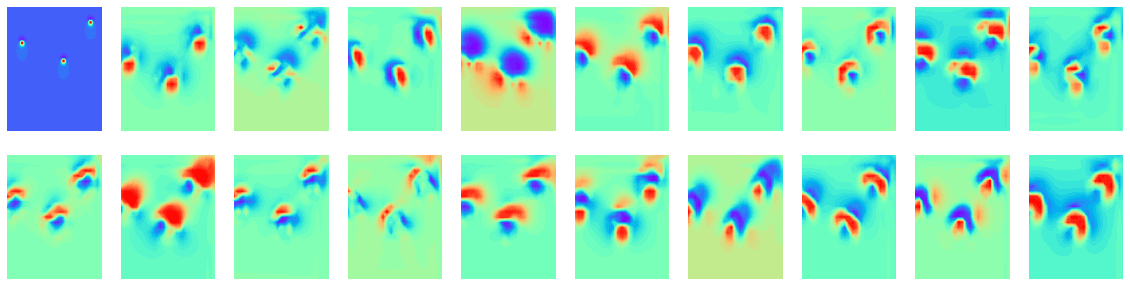

In [ ]:
convolutional_layers_plot(example_layer_output[0][:,:,:20], X_test[Example_to_verify])

In [ ]:
#saved_model.summary()

#tensorflow.keras.utils.plot_model(saved_model, 'multi_input_and_output_model.png', show_shapes=True)